# Reliability classifiers 
## Overview 
todo:


## Dimensions for making the problem harder: 
1. ~Generating from lots of different shape, scale parameters. E.g. wearout_01 has shape=2.0, wearout_02 has shape=4.2, etc.~ 
2. ~Varying sample sizes. In particular, smaller sample sizes can be hard to classify~
4. ~Mixtures of distributions. E.g. many IM cases are actually IM+WO~
5. ~Adding noise (e.g. uniform distribution)~ 
6. ~Transforming to a multilabel classification problem~ 
7. Matching expected values when generating data. E.g. for a pair of weibulls, if first distribution has shape=.8 and scale=1.0, and the second has shape=1.1, then we calculate the required scale as 1.083. 

## Next steps 
1. ~See data gen in 2023-04-17_nn-classifier-for-weibull-shape. Run simple models in that nb and check performance. Use same data gen method from that nb here.~ 

In [30]:
import sys
print(sys.executable)

/opt/conda/bin/python3.10


In [31]:
import numpy as np
from scipy.stats import weibull_min, uniform
import scipy.special
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set the random seed
np.random.seed(2023)

# Problem params 

In [32]:
# Number of samples per class
n_samples_per_class = 10000

# Number of features
n_features = 50

# Scale parameter (constant for both classes)
scale_im = 1.0 

# Shape parameters for the two classes
shape_parameter_infant = 0.8  # Values tried: 0.8, 1.0,
shape_parameter_wearout = 1.1  # Values tried: 2.0, 1.1, 1.2

# Calculate scale_wearout to match expected values with im 
mean_im = scipy.special.gamma(1+1/shape_parameter_infant)
scale_wo = mean_im/scipy.special.gamma(1 + 1/shape_parameter_wearout)
# scale_wo = scale_im 

In [33]:
mean_im

1.1330030963193463

In [34]:
mean_wo = scale_wo * scipy.special.gamma(1+1/shape_parameter_wearout)
mean_wo

1.1330030963193463

# Data generation

In [35]:
# Generate samples for class "infant mortality"
infant_mortality_features = weibull_min.rvs(shape_parameter_infant, scale=scale_im, size=(n_samples_per_class, n_features))
infant_mortality_labels = np.zeros(n_samples_per_class)


# Generate samples for class "wearout"
## Using Weibull distribution: 
wearout_features = weibull_min.rvs(shape_parameter_wearout, scale=scale_wo, size=(n_samples_per_class, n_features))
wearout_labels = np.ones(n_samples_per_class)

## Using uniform distribution: 
# uniform_features = uniform.rvs(loc=0, scale=scale_wo*5, size=(n_samples_per_class, n_features))
# uniform_labels = np.ones(n_samples_per_class)

# Combine all data
features = np.vstack((infant_mortality_features, wearout_features))
labels = np.concatenate((infant_mortality_labels, wearout_labels))

# Shuffle the data
shuffle_idx = np.random.permutation(features.shape[0])
features = features[shuffle_idx]
labels = labels[shuffle_idx]

# Convert to a DataFrame for display 
df_data = pd.DataFrame(features)
df_data['class'] = labels
df_data['class_desc'] = df_data['class'].map({0: 'infant mortality', 1: 'wearout'})

In [36]:
df_data.shape

(20000, 52)

In [37]:
# Print the first few rows to check
df_data.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,class,class_desc
0,2.240013,1.936090,0.102584,0.158636,0.880068,1.936839,0.232908,1.637445,0.097616,0.225095,...,0.162555,0.528425,0.925774,0.208170,0.780530,0.803112,2.083448,1.181199,0.0,infant mortality
1,1.524344,0.471411,0.615181,0.002074,0.490937,0.656194,0.685337,1.412579,3.349617,0.665072,...,0.281525,0.301898,0.400021,3.373669,1.563070,0.399806,1.551178,2.103357,1.0,wearout
2,2.134908,0.037937,0.451281,3.037385,0.045308,0.098219,8.444609,0.104448,1.365238,0.223275,...,0.430042,7.630464,0.077788,2.262929,0.092709,0.308726,1.336683,0.796414,0.0,infant mortality
3,3.481317,0.083301,3.089485,0.894254,0.481035,0.642092,0.487093,0.459114,1.087120,2.344689,...,0.061777,1.394920,0.587765,2.250961,0.692278,1.541556,0.868268,0.571578,0.0,infant mortality
4,0.152973,0.286436,0.159871,2.065661,0.086489,0.679158,0.540024,1.150315,3.872983,0.437683,...,0.004348,0.913601,1.456800,0.230442,0.048887,4.500432,1.723132,0.062476,0.0,infant mortality


In [38]:
df_data.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,class,class_desc
14972,0.895811,1.988558,0.613695,0.505946,0.973408,0.782099,0.281534,1.929595,0.697758,1.664471,...,1.497990,1.288758,0.012343,0.062412,1.943809,3.434471,0.068735,0.235082,1.0,wearout
14499,0.681356,0.647610,0.689974,0.609778,1.229387,0.553947,2.737301,1.312584,0.179555,0.928591,...,0.321099,4.701683,1.478930,0.061641,0.194731,2.955862,0.990172,0.163199,1.0,wearout
14612,4.187984,0.401632,3.069642,0.428031,1.034977,0.794151,3.931342,2.112249,0.812114,0.837027,...,0.541124,0.303003,4.208846,3.928752,0.131052,0.934781,1.283922,0.004232,0.0,infant mortality
2031,1.818580,3.000313,0.355329,1.500723,2.968264,1.502703,0.453361,1.466136,0.693261,1.181282,...,3.226927,2.225827,0.399413,0.938601,0.218838,1.242721,0.370948,3.947347,1.0,wearout
17737,1.177465,0.927514,0.003116,0.525981,0.724823,0.338795,0.054226,1.020131,0.399046,0.193706,...,0.594767,1.480039,0.093025,0.151725,0.327602,0.078050,0.533258,0.828505,1.0,wearout
563,1.742687,1.369397,2.938457,0.530135,0.195119,0.133518,0.210653,5.332642,0.951194,2.797407,...,0.404549,0.447305,1.260156,1.134245,3.421758,0.978163,0.269889,0.454131,1.0,wearout
7968,0.001771,0.178311,0.331648,0.121294,2.044157,0.124030,3.406918,0.156651,0.322317,1.063027,...,0.224360,0.324759,0.608475,1.360565,8.539881,1.510166,0.875063,1.508250,0.0,infant mortality
17929,2.456054,7.273998,0.015084,0.201628,0.605978,1.890126,11.158801,0.000581,1.910562,0.854753,...,2.199634,1.850492,0.085762,0.023377,0.299808,0.033552,0.880694,0.249577,0.0,infant mortality
16589,0.025966,0.042883,2.435360,2.822002,0.659354,0.208092,0.214777,1.919541,0.154849,1.701756,...,0.273615,0.093464,0.389586,0.089632,0.329413,0.044059,0.113626,0.276538,0.0,infant mortality
11245,0.519120,0.315979,1.200814,1.197537,0.047717,2.343161,0.407656,0.621267,0.787354,1.160246,...,1.343080,0.430975,0.796086,0.161501,2.436495,1.751579,1.869181,0.932495,1.0,wearout


# Plots

In [39]:
# nrow = 10
# ncol = 5
# fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
# ax_flat = axes.flatten()

# for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
#     selected_sample = features[sample_index]
#     ax.hist(selected_sample, bins=20, edgecolor='black')
#     ax.set_title(f'Sample {sample_index+1} {"IM" if labels[sample_index] == 0 else "WO"}')
#     ax.grid(True)

# plt.tight_layout()
# plt.show();


In [40]:
# nrow = 10
# ncol = 5
# fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
# ax_flat = axes.flatten()

# for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
#     selected_sample = features[sample_index]
#     ecdf = ECDF(selected_sample)

#     ax.step(ecdf.x, ecdf.y, where='post')
#     ax.set_title(f'Sample {sample_index+1} {"IM" if labels[sample_index] == 0 else "WO"}')
#     ax.grid(True)

# plt.tight_layout()
# plt.show();

# Train-test split 

In [41]:
X = df_data.iloc[:, :-2].values
X.shape
type(X)

(20000, 50)

numpy.ndarray

In [42]:
y = df_data.iloc[:, -2:-1].values.squeeze()
y.shape 
type(y)

(20000,)

numpy.ndarray

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2023)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=2023)

X_train.shape
X_valid.shape 
X_test.shape 

y_train.shape
y_valid.shape
y_test.shape


(12800, 50)

(3200, 50)

(4000, 50)

(12800,)

(3200,)

(4000,)

# Models

In [44]:
model_dict = {
    0: LogisticRegression(random_state=11), 
    1: RandomForestClassifier(random_state=11), 
    2: xgb.XGBClassifier(objective="binary:logistic", random_state=11)
}

# Training functions and evaluation functions

In [45]:
def train_model(model_num, X_train=X_train, y_train=y_train, X_valid=X_valid): 
    m = model_dict.get(model_num)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    return preds 

def evaluate_model(y, y_pred, model_desc=''): 
    cr = classification_report(y, y_pred)
    print(cr) 
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f'{model_desc}')
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    plt.plot()
    

def train_eval_pipeline(model_num, _X_train=X_train, _y_train=y_train, _X_valid=X_valid, _y_valid=y_valid): 
    model_desc = model_dict.get(model_num)
    print(f'\n\nmodel: {model_desc}')
    preds_valid = train_model(model_num, _X_train, _y_train, _X_valid)
    evaluate_model(_y_valid, preds_valid, model_desc)

# Training and model selection




model: LogisticRegression(random_state=11)
              precision    recall  f1-score   support

         0.0       0.54      0.48      0.50      1627
         1.0       0.51      0.57      0.54      1573

    accuracy                           0.52      3200
   macro avg       0.52      0.52      0.52      3200
weighted avg       0.53      0.52      0.52      3200



model: RandomForestClassifier(random_state=11)
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1627
         1.0       0.89      0.85      0.87      1573

    accuracy                           0.87      3200
   macro avg       0.87      0.87      0.87      3200
weighted avg       0.87      0.87      0.87      3200



model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None

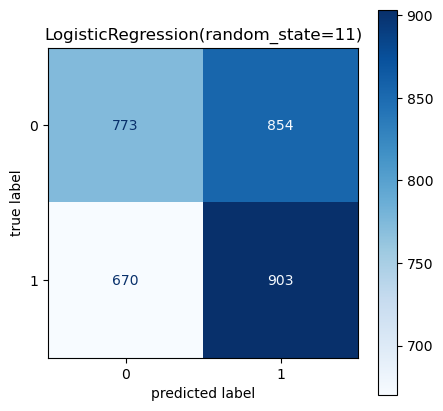

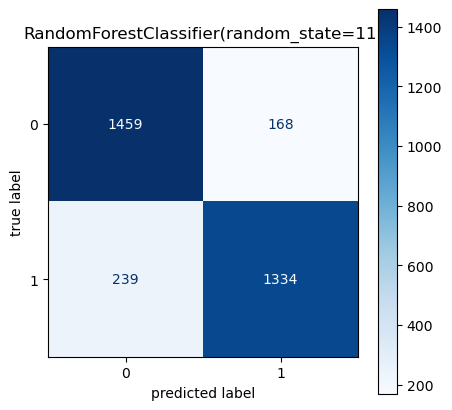

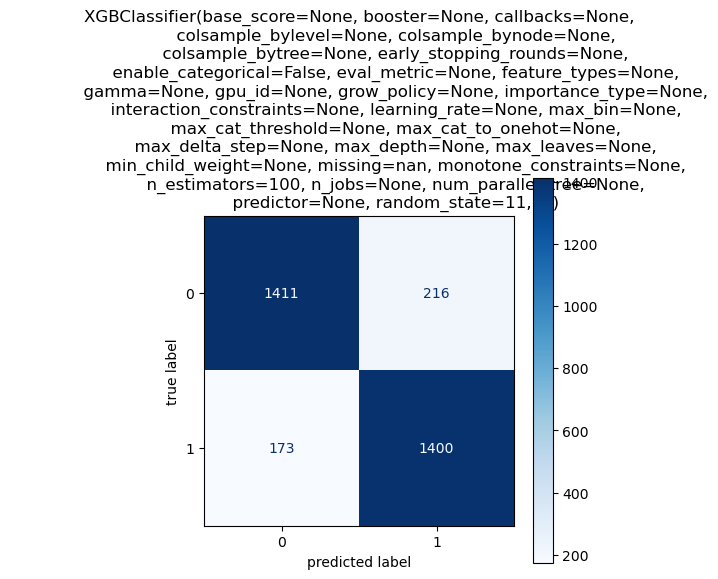

In [46]:
for model in model_dict.keys(): 
    train_eval_pipeline(model)

## Examining feature distributions

In [47]:
df = pd.concat((pd.DataFrame(X_train), pd.DataFrame(pd.Series(y_train, name='target'))), axis=1)

df = df.rename(columns={df.columns[-1]: 'target'})
df.iloc[:, list(range(10)) + [-1]].sample(n=10)

,0,1,2,3,4,5,6,7,8,9,target
4099,2.122477,0.493456,0.719400,1.722811,0.666147,0.073089,0.007421,1.278298,1.892656,0.312146,1.0
6662,1.727451,0.114583,2.352946,0.063365,0.099365,2.474159,1.227542,0.240721,0.220905,0.143759,0.0
11555,0.904042,1.056588,1.653765,0.915641,0.238006,2.574096,0.386426,2.327814,0.889739,0.356795,1.0
11477,2.260590,0.395245,0.168977,1.316103,0.723439,0.433854,0.134077,0.421627,1.128920,0.042804,0.0
3676,0.538667,4.664469,0.028387,0.435713,1.006022,0.142201,0.176634,1.063336,0.455157,0.244710,0.0
10348,0.036702,0.308801,0.119703,0.139868,0.940790,2.462403,1.103236,0.023051,0.042426,0.271801,0.0
1197,0.472994,1.148585,1.004611,0.442818,1.326442,1.610063,1.128356,3.252421,0.077495,0.092006,0.0
1892,0.667543,1.877119,2.390399,0.008807,0.400646,1.467429,0.121273,0.142944,1.258568,0.339704,1.0
7323,0.435234,1.344707,0.760605,1.552492,0.887367,0.427393,0.604282,0.978134,0.136670,0.883993,1.0
4532,2.566497,0.295927,2.547938,0.829861,4.742965,2.967213,0.337779,0.761907,0.311796,0.976541,1.0


In [48]:
results = []

for col in df.columns[:10]:
    group_stats = df.groupby('target')[col].describe(percentiles=[.25, .5, .75])
    mean = df.groupby('target')[col].mean()
    group_stats['mean'] = mean
    group_stats['range'] = group_stats['max'] - group_stats['min']
    results.append(group_stats[['mean', '50%', '25%', '75%', 'min', 'max', 'range']])

# Concatenate results
result_df = pd.concat(results, keys=df.columns[:10])
result_df.rename(columns={'50%': 'median', '25%': 'Q1', '75%': 'Q3'}, inplace=True)

result_df

mean    median        Q1        Q3           min        max  \
  target                                                                    
0 0.0     1.142622  0.642816  0.213598  1.527595  1.441984e-05  13.558771   
  1.0     1.132904  0.850549  0.379164  1.592181  2.074043e-04   9.198163   
1 0.0     1.134887  0.642779  0.208468  1.475680  4.511235e-05  20.869345   
  1.0     1.128693  0.844230  0.388503  1.567030  3.058379e-04   9.794307   
2 0.0     1.143975  0.650021  0.216269  1.517480  7.872372e-06  16.413591   
  1.0     1.137781  0.840810  0.375110  1.564092  2.613689e-04   8.092568   
3 0.0     1.147203  0.628662  0.207824  1.521996  1.317347e-05  18.669351   
  1.0     1.135008  0.856403  0.382183  1.589837  3.781453e-04   9.113999   
4 0.0     1.150657  0.641096  0.215439  1.540401  4.649123e-06  13.714107   
  1.0     1.126879  0.842411  0.372452  1.584668  6.065366e-06   7.338590   
5 0.0     1.112063  0.613784  0.210116  1.498563  7.795207e-07  16.127676   
  1.0     1.138581  0.855570  0.388279  1.577877  6.739326e-05   8.682130   
6 0.0     1.162278  0.650442  0.215983  1.525495  1.136477e-06  20.740524   
  1.0     1.143777  0.863420  0.392435  1.587948  5.865900e-04   7.878286   
7 0.0     1.115520  0.633600  0.204402  1.456283  6.742025e-06  15.180550   
  1.0     1.138543  0.854386  0.377941  1.602514  3.476524e-04   7.777263   
8 0.0     1.131222  0.613782  0.211019  1.518725  3.031678e-05  14.093107   
  1.0     1.132398  0.841697  0.390156  1.603790  9.875361e-05   8.630427   
9 0.0     1.140510  0.650554  0.214885  1.511337  3.063216e-07  14.859460   
  1.0     1.136442  0.837516  0.362724  1.581834  1.532581e-04   9.210266   

              range  
  target             
0 0.0     13.558757  
  1.0      9.197956  
1 0.0     20.869300  
  1.0      9.794001  
2 0.0     16.413583  
  1.0      8.092307  
3 0.0     18.669337  
  1.0      9.113621  
4 0.0     13.714102  
  1.0      7.338584  
5 0.0     16.127675  
  1.0      8.682062  
6 0.0     20.740523  
  1.0      7.877700  
7 0.0     15.180544  
  1.0      7.776915  
8 0.0     14.093077  
  1.0      8.630329  
9 0.0     14.859459  
  1.0      9.210113

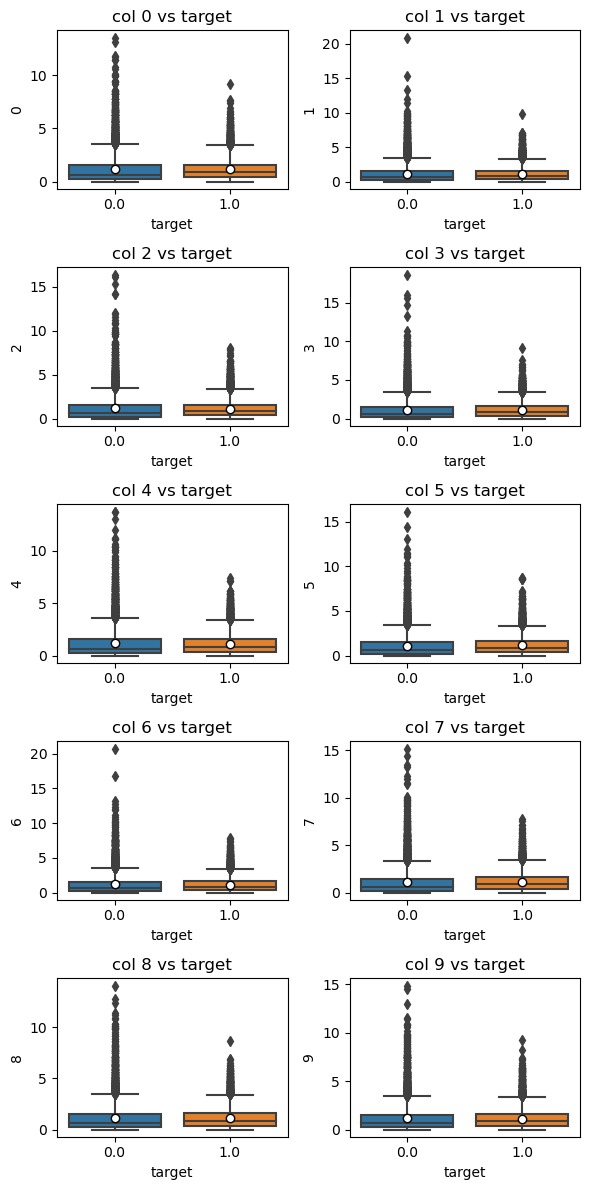

In [49]:
fig, axes = plt.subplots(5, 2, figsize=(6,12))
meanprops = {"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"}

for idx, col in enumerate(df.columns[:10]):
    row, col_idx = divmod(idx, 2)
    
    df_log = pd.concat((np.log(df[col]), df[['target']]), axis=1)
    sns.boxplot(
        x='target', y=col, data=df, ax=axes[row, col_idx],
        showmeans=True, meanprops=meanprops
    )
    axes[row, col_idx].set_title(f'col {col} vs target')

plt.tight_layout()
plt.show();

# Retraining selected model and running inference 

In [50]:
X_train_and_valid = np.concatenate((X_train, X_valid), axis=0)
y_train_and_valid = np.concatenate((y_train, y_valid), axis=0)



model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=11, ...)
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88      2013
         1.0       0.87      0.90      0.88      1987

    accuracy                           0.88      4000
   macro avg       0.88

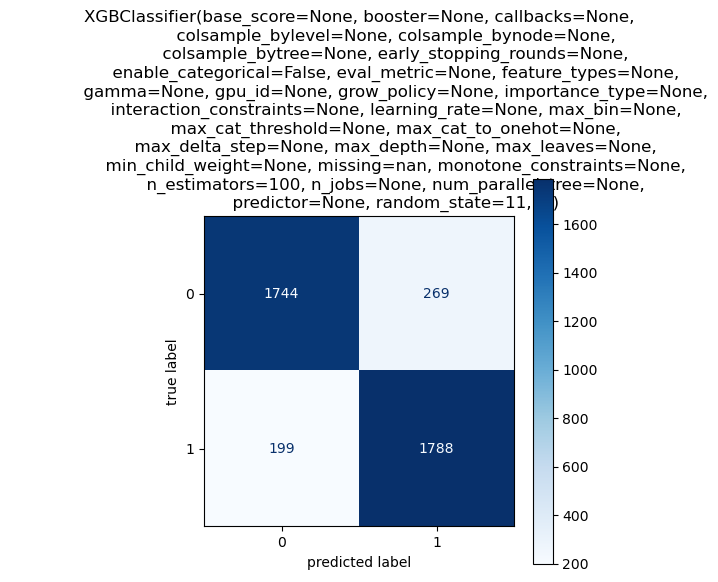

In [51]:
selected_model_num = 2
train_eval_pipeline(selected_model_num, X_train_and_valid, y_train_and_valid, X_test, y_test)